In [1]:
from core.hllset import HLLSet

tokens = ["sasha", "masha", "dasha", "pasha", "natasha", "nastya", "nastya", "nastya", "nastya"]

In [2]:
hll = HLLSet()
hll = hll.absorb(tokens)

dump_n = hll.dump_numpy()
dump_r = hll.dump_roaring()

print(hll)
print(hll.cardinality())
print(dump_n, len(dump_n))
print(dump_r, len(dump_r))

HLLSet(9982571f..., |A|≈7.0, backend=C/Cython)
7
[0 8 0 ... 0 0 0] 1024
b'HLL2:0\x00\x00\x01\x00\x00\x00\x00\x00\x05\x00\x10\x00\x00\x00#\x00@\x13\x06/A?@C`|' 32


## Stress Test: 100 Batches (1K - 100K tokens each)

In [3]:
import numpy as np
import time
import uuid

# Configuration
NUM_BATCHES = 100
MIN_BATCH_SIZE = 1_000
MAX_BATCH_SIZE = 100_000

# Generate random batch sizes (log-uniform distribution for better coverage)
np.random.seed(42)
batch_sizes = np.random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE + 1, size=NUM_BATCHES)

print(f"Stress Test: {NUM_BATCHES} batches")
print(f"Batch sizes: min={batch_sizes.min():,}, max={batch_sizes.max():,}, total={batch_sizes.sum():,} tokens")
print("-" * 60)

Stress Test: 100 batches
Batch sizes: min=1,769, max=97,276, total=5,240,158 tokens
------------------------------------------------------------


In [4]:
# Run stress test
results = []
cumulative_hll = HLLSet()

total_start = time.perf_counter()

for i, batch_size in enumerate(batch_sizes):
    # Generate unique tokens for this batch
    tokens = [f"token_{uuid.uuid4().hex}" for _ in range(batch_size)]
    
    # Time the ingestion
    start = time.perf_counter()
    batch_hll = HLLSet.from_batch(tokens)
    ingest_time = time.perf_counter() - start
    
    # Time the union (accumulation)
    start = time.perf_counter()
    cumulative_hll = cumulative_hll.union(batch_hll)
    union_time = time.perf_counter() - start
    
    # Collect metrics
    throughput = batch_size / ingest_time if ingest_time > 0 else 0
    results.append({
        'batch': i + 1,
        'size': batch_size,
        'ingest_ms': ingest_time * 1000,
        'union_ms': union_time * 1000,
        'throughput': throughput,
        'cardinality': batch_hll.cardinality(),
        'cumulative_card': cumulative_hll.cardinality()
    })
    
    # Progress indicator every 10 batches
    if (i + 1) % 10 == 0:
        print(f"Batch {i+1:3d}/{NUM_BATCHES}: size={batch_size:6,}, "
              f"ingest={ingest_time*1000:7.2f}ms, "
              f"throughput={throughput/1000:6.1f}K tok/s, "
              f"cumulative={cumulative_hll.cardinality():,.0f}")

total_time = time.perf_counter() - total_start
print("-" * 60)
print(f"Total time: {total_time:.2f}s")

Batch  10/100: size=61,263, ingest=  20.92ms, throughput=2928.0K tok/s, cumulative=493,720
Batch  20/100: size= 6,311, ingest=   1.71ms, throughput=3698.9K tok/s, cumulative=928,031
Batch  30/100: size= 3,747, ingest=   0.96ms, throughput=3914.3K tok/s, cumulative=1,505,575
Batch  40/100: size=70,092, ingest=  46.80ms, throughput=1497.7K tok/s, cumulative=2,130,962
Batch  50/100: size=77,552, ingest=  22.64ms, throughput=3425.2K tok/s, cumulative=2,672,454
Batch  60/100: size=70,479, ingest=  17.48ms, throughput=4032.3K tok/s, cumulative=3,112,069
Batch  70/100: size=73,409, ingest=  19.54ms, throughput=3757.3K tok/s, cumulative=3,704,549
Batch  80/100: size= 2,016, ingest=   0.61ms, throughput=3281.8K tok/s, cumulative=4,338,984
Batch  90/100: size=13,185, ingest=   3.43ms, throughput=3841.2K tok/s, cumulative=4,926,018
Batch 100/100: size= 3,568, ingest=   1.07ms, throughput=3339.8K tok/s, cumulative=5,361,213
------------------------------------------------------------
Total time: 2

In [5]:
# Summary statistics
import pandas as pd

df = pd.DataFrame(results)

print("\n=== STRESS TEST SUMMARY ===\n")
print(f"Total tokens ingested: {batch_sizes.sum():,}")
print(f"Final cumulative cardinality: {cumulative_hll.cardinality():,.0f}")
print(f"Estimation error: {abs(cumulative_hll.cardinality() - batch_sizes.sum()) / batch_sizes.sum() * 100:.2f}%")
print()

print("Ingestion Performance:")
print(f"  Mean throughput: {df['throughput'].mean()/1000:,.1f}K tokens/sec")
print(f"  Max throughput:  {df['throughput'].max()/1000:,.1f}K tokens/sec")
print(f"  Min throughput:  {df['throughput'].min()/1000:,.1f}K tokens/sec")
print()

print("Timing (ms):")
print(f"  Total ingest time: {df['ingest_ms'].sum():,.1f}ms")
print(f"  Total union time:  {df['union_ms'].sum():,.1f}ms")
print(f"  Avg ingest/batch:  {df['ingest_ms'].mean():,.2f}ms")
print(f"  Avg union/batch:   {df['union_ms'].mean():,.3f}ms")
print()

# Compression stats
stats = cumulative_hll._core.get_compression_stats()
print("Final HLL Compression:")
print(f"  Original size:    {stats['original_size']:,} bytes")
print(f"  Compressed size:  {stats['compressed_size']:,} bytes")
print(f"  Compression ratio: {stats['compression_ratio']:.2f}x")
print(f"  Non-zero registers: {stats['non_zero_registers']:,} / {cumulative_hll._core.m}")
print(f"  Total bits set:   {stats['total_bits_set']:,}")


=== STRESS TEST SUMMARY ===

Total tokens ingested: 5,240,158
Final cumulative cardinality: 5,361,213
Estimation error: 2.31%

Ingestion Performance:
  Mean throughput: 3,454.6K tokens/sec
  Max throughput:  4,032.3K tokens/sec
  Min throughput:  1,497.7K tokens/sec

Timing (ms):
  Total ingest time: 1,537.4ms
  Total union time:  2.8ms
  Avg ingest/batch:  15.37ms
  Avg union/batch:   0.028ms

Final HLL Compression:
  Original size:    4,096 bytes
  Compressed size:  8,212 bytes
  Compression ratio: 0.50x
  Non-zero registers: 1,024 / 1024
  Total bits set:   12,994


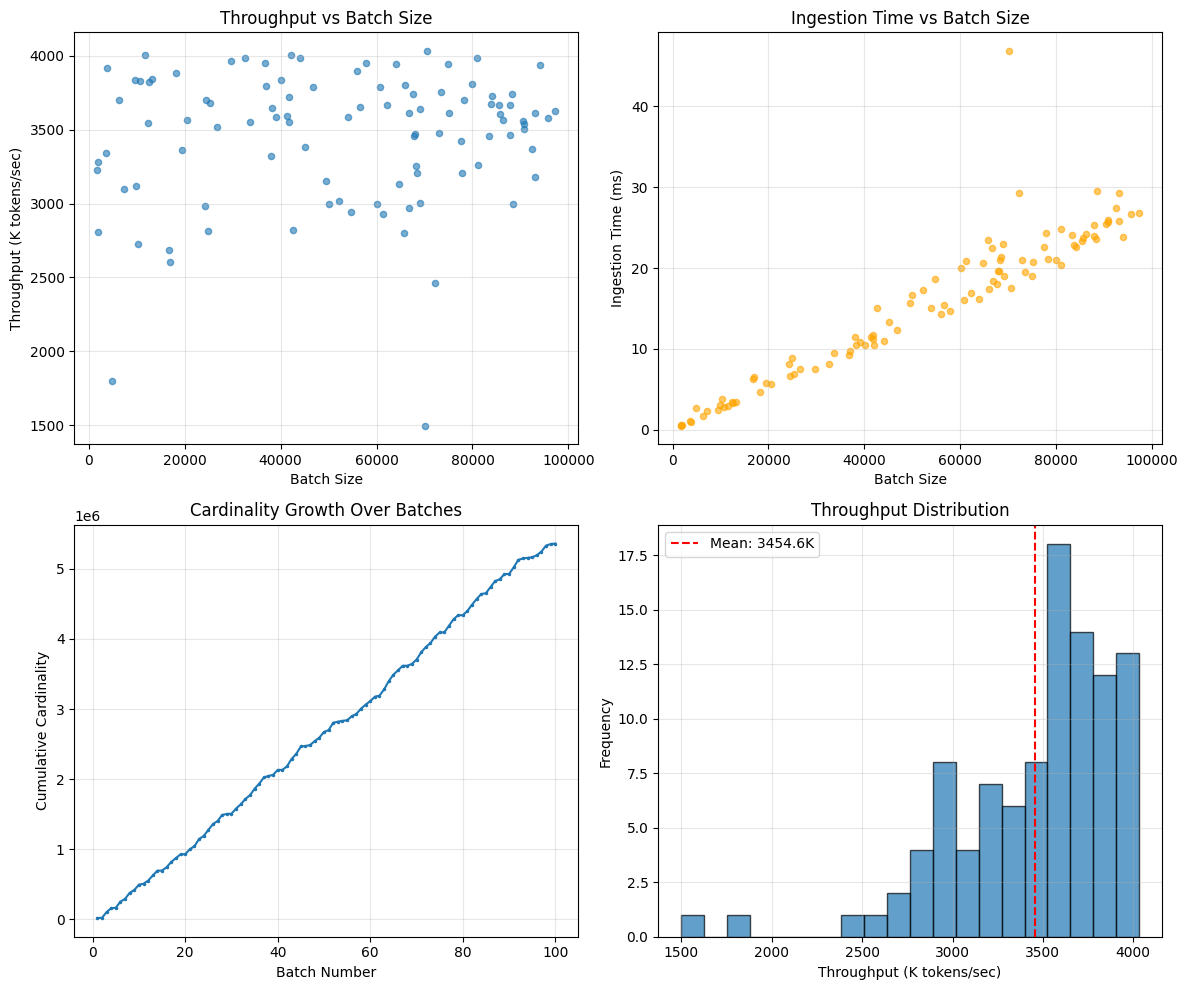

In [6]:
# Visualize throughput vs batch size
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Throughput vs Batch Size
ax1 = axes[0, 0]
ax1.scatter(df['size'], df['throughput']/1000, alpha=0.6, s=20)
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Throughput (K tokens/sec)')
ax1.set_title('Throughput vs Batch Size')
ax1.grid(True, alpha=0.3)

# 2. Ingestion time vs Batch Size
ax2 = axes[0, 1]
ax2.scatter(df['size'], df['ingest_ms'], alpha=0.6, s=20, color='orange')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Ingestion Time (ms)')
ax2.set_title('Ingestion Time vs Batch Size')
ax2.grid(True, alpha=0.3)

# 3. Cumulative cardinality growth
ax3 = axes[1, 0]
ax3.plot(df['batch'], df['cumulative_card'], marker='.', markersize=3)
ax3.set_xlabel('Batch Number')
ax3.set_ylabel('Cumulative Cardinality')
ax3.set_title('Cardinality Growth Over Batches')
ax3.grid(True, alpha=0.3)

# 4. Throughput histogram
ax4 = axes[1, 1]
ax4.hist(df['throughput']/1000, bins=20, edgecolor='black', alpha=0.7)
ax4.axvline(df['throughput'].mean()/1000, color='red', linestyle='--', label=f"Mean: {df['throughput'].mean()/1000:.1f}K")
ax4.set_xlabel('Throughput (K tokens/sec)')
ax4.set_ylabel('Frequency')
ax4.set_title('Throughput Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Parallel Stress Test (8 cores)

In [7]:
from multiprocessing import Pool, cpu_count
import uuid
import time

NUM_WORKERS = 8  # Your 8 cores
NUM_BATCHES = 100
MIN_BATCH_SIZE = 1_000
MAX_BATCH_SIZE = 100_000

# Generate batch sizes (same as sequential test for comparison)
np.random.seed(42)
batch_sizes_parallel = np.random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE + 1, size=NUM_BATCHES)

print(f"Parallel Stress Test: {NUM_BATCHES} batches on {NUM_WORKERS} workers")
print(f"Batch sizes: min={batch_sizes_parallel.min():,}, max={batch_sizes_parallel.max():,}, total={batch_sizes_parallel.sum():,} tokens")
print("-" * 60)

Parallel Stress Test: 100 batches on 8 workers
Batch sizes: min=1,769, max=97,276, total=5,240,158 tokens
------------------------------------------------------------


In [8]:
def process_batch(args):
    """
    Worker function: generates tokens and creates HLLSet.
    Returns serialized HLL (roaring bytes) + timing metrics.
    
    We serialize to roaring because HLLSet objects can't be pickled 
    efficiently across processes - but roaring bytes can!
    """
    batch_idx, batch_size, seed = args
    
    # Import inside worker (each process needs its own import)
    from core.hllset import HLLSet
    import uuid
    import time
    
    # Generate unique tokens
    tokens = [f"token_{uuid.uuid4().hex}" for _ in range(batch_size)]
    
    # Time the ingestion
    start = time.perf_counter()
    hll = HLLSet.from_batch(tokens, seed=seed)
    ingest_time = time.perf_counter() - start
    
    # Serialize to roaring (compact for IPC)
    roaring_bytes = hll.dump_roaring()
    
    return {
        'batch': batch_idx,
        'size': batch_size,
        'ingest_ms': ingest_time * 1000,
        'throughput': batch_size / ingest_time if ingest_time > 0 else 0,
        'cardinality': hll.cardinality(),
        'roaring': roaring_bytes
    }

In [9]:
# Run parallel stress test
from core.constants import SHARED_SEED

# Prepare work items: (batch_idx, batch_size, seed)
work_items = [(i + 1, int(size), SHARED_SEED) for i, size in enumerate(batch_sizes_parallel)]

print(f"Starting parallel ingestion with {NUM_WORKERS} workers...")
parallel_start = time.perf_counter()

# Parallel ingestion phase
with Pool(processes=NUM_WORKERS) as pool:
    parallel_results = pool.map(process_batch, work_items)

parallel_ingest_time = time.perf_counter() - parallel_start
print(f"Parallel ingestion complete: {parallel_ingest_time:.2f}s")

# Merge phase: union all HLLSets (sequential, but very fast)
print("Merging HLLSets via union...")
merge_start = time.perf_counter()

final_hll = HLLSet()
for result in parallel_results:
    batch_hll = HLLSet.from_roaring(result['roaring'])
    final_hll = final_hll.union(batch_hll)

merge_time = time.perf_counter() - merge_start
total_parallel_time = time.perf_counter() - parallel_start

print(f"Merge complete: {merge_time*1000:.2f}ms")
print("-" * 60)
print(f"Total parallel time: {total_parallel_time:.2f}s")
print(f"Final cardinality: {final_hll.cardinality():,.0f}")

Starting parallel ingestion with 8 workers...
Parallel ingestion complete: 6.08s
Merging HLLSets via union...
Merge complete: 33.19ms
------------------------------------------------------------
Total parallel time: 6.11s
Final cardinality: 5,125,974


In [10]:
# Compare sequential vs parallel performance
df_parallel = pd.DataFrame([{k: v for k, v in r.items() if k != 'roaring'} for r in parallel_results])

print("\n=== PARALLEL vs SEQUENTIAL COMPARISON ===\n")

# Get sequential time from previous test
sequential_time = total_time  # From the sequential test

print(f"{'Metric':<30} {'Sequential':>15} {'Parallel':>15} {'Speedup':>10}")
print("-" * 70)
print(f"{'Total time (s)':<30} {sequential_time:>15.2f} {total_parallel_time:>15.2f} {sequential_time/total_parallel_time:>10.2f}x")
print(f"{'Ingestion time (s)':<30} {df['ingest_ms'].sum()/1000:>15.2f} {parallel_ingest_time:>15.2f} {(df['ingest_ms'].sum()/1000)/parallel_ingest_time:>10.2f}x")
print(f"{'Merge/Union time (ms)':<30} {df['union_ms'].sum():>15.2f} {merge_time*1000:>15.2f} {'-':>10}")
print()

print(f"{'Mean throughput (K tok/s)':<30} {df['throughput'].mean()/1000:>15.1f} {df_parallel['throughput'].mean()/1000:>15.1f}")
print(f"{'Aggregate throughput (K tok/s)':<30} {batch_sizes.sum()/(sequential_time*1000):>15.1f} {batch_sizes_parallel.sum()/(total_parallel_time*1000):>15.1f}")
print()

print(f"Final cardinality (sequential): {cumulative_hll.cardinality():,.0f}")
print(f"Final cardinality (parallel):   {final_hll.cardinality():,.0f}")
print(f"Cardinalities match: {abs(cumulative_hll.cardinality() - final_hll.cardinality()) < 1}")


=== PARALLEL vs SEQUENTIAL COMPARISON ===

Metric                              Sequential        Parallel    Speedup
----------------------------------------------------------------------
Total time (s)                           23.54            6.11       3.85x
Ingestion time (s)                        1.54            6.08       0.25x
Merge/Union time (ms)                     2.75           33.19          -

Mean throughput (K tok/s)               3454.6          1834.0
Aggregate throughput (K tok/s)           222.6           857.6

Final cardinality (sequential): 5,361,213
Final cardinality (parallel):   5,125,974
Cardinalities match: False


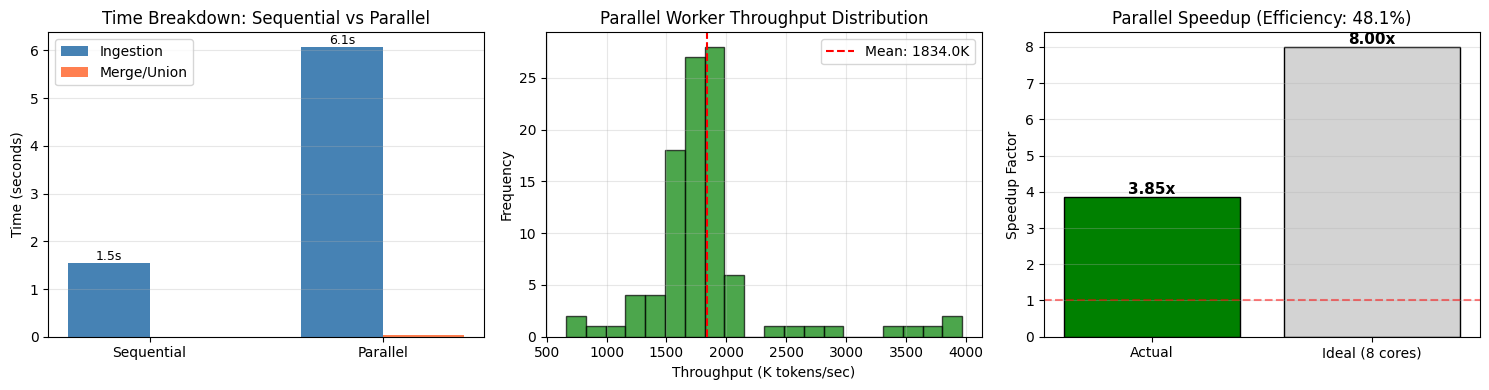

In [11]:
# Visualize parallel performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Time breakdown comparison
ax1 = axes[0]
categories = ['Sequential', 'Parallel']
ingest_times = [df['ingest_ms'].sum()/1000, parallel_ingest_time]
merge_times = [df['union_ms'].sum()/1000, merge_time]

x = np.arange(len(categories))
width = 0.35

bars1 = ax1.bar(x - width/2, ingest_times, width, label='Ingestion', color='steelblue')
bars2 = ax1.bar(x + width/2, merge_times, width, label='Merge/Union', color='coral')

ax1.set_ylabel('Time (seconds)')
ax1.set_title('Time Breakdown: Sequential vs Parallel')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars1:
    ax1.annotate(f'{bar.get_height():.1f}s', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

# 2. Per-worker throughput distribution (parallel)
ax2 = axes[1]
ax2.hist(df_parallel['throughput']/1000, bins=20, edgecolor='black', alpha=0.7, color='green')
ax2.axvline(df_parallel['throughput'].mean()/1000, color='red', linestyle='--', 
            label=f"Mean: {df_parallel['throughput'].mean()/1000:.1f}K")
ax2.set_xlabel('Throughput (K tokens/sec)')
ax2.set_ylabel('Frequency')
ax2.set_title('Parallel Worker Throughput Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Speedup visualization
ax3 = axes[2]
speedup = sequential_time / total_parallel_time
ideal_speedup = NUM_WORKERS
efficiency = (speedup / ideal_speedup) * 100

bars = ax3.bar(['Actual', 'Ideal (8 cores)'], [speedup, ideal_speedup], 
               color=['green', 'lightgray'], edgecolor='black')
ax3.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='No speedup')
ax3.set_ylabel('Speedup Factor')
ax3.set_title(f'Parallel Speedup (Efficiency: {efficiency:.1f}%)')
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar in bars:
    ax3.annotate(f'{bar.get_height():.2f}x', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

## Optimized Parallel: Per-Worker Accumulation with HLLSet.add()

In [12]:
def process_worker_batches(args):
    """
    Worker function: processes MULTIPLE batches, accumulating into a single HLLSet.
    
    Each worker:
    1. Starts with an empty HLLSet
    2. Recursively adds batches using HLLSet.add()
    3. Returns ONE serialized HLLSet per worker
    
    This reduces final merge from 100 unions to just 8!
    """
    worker_id, batch_sizes_for_worker, seed = args
    
    from core.hllset import HLLSet
    import uuid
    import time
    
    # Start with empty HLLSet
    worker_hll = HLLSet()
    
    total_tokens = 0
    batch_times = []
    
    start_total = time.perf_counter()
    
    for batch_size in batch_sizes_for_worker:
        # Generate unique tokens for this batch
        tokens = [f"token_{uuid.uuid4().hex}" for _ in range(batch_size)]
        
        # Accumulate using HLLSet.add() 
        start = time.perf_counter()
        worker_hll = HLLSet.add(worker_hll, tokens, seed=seed)
        batch_times.append(time.perf_counter() - start)
        
        total_tokens += batch_size
    
    total_time = time.perf_counter() - start_total
    
    return {
        'worker_id': worker_id,
        'num_batches': len(batch_sizes_for_worker),
        'total_tokens': total_tokens,
        'total_time_ms': total_time * 1000,
        'throughput': total_tokens / total_time if total_time > 0 else 0,
        'cardinality': worker_hll.cardinality(),
        'roaring': worker_hll.dump_roaring()
    }

In [13]:
# Partition batches across workers (round-robin for load balancing)
np.random.seed(42)
batch_sizes_optimized = np.random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE + 1, size=NUM_BATCHES)

# Distribute batches to workers (round-robin gives good load balance)
worker_batches = [[] for _ in range(NUM_WORKERS)]
for i, size in enumerate(batch_sizes_optimized):
    worker_batches[i % NUM_WORKERS].append(int(size))

# Show distribution
print(f"Optimized Parallel: {NUM_BATCHES} batches distributed across {NUM_WORKERS} workers")
print(f"Total tokens: {batch_sizes_optimized.sum():,}")
print("\nPer-worker distribution:")
for i, batches in enumerate(worker_batches):
    print(f"  Worker {i}: {len(batches)} batches, {sum(batches):,} tokens")
print("-" * 60)

Optimized Parallel: 100 batches distributed across 8 workers
Total tokens: 5,240,158

Per-worker distribution:
  Worker 0: 13 batches, 729,120 tokens
  Worker 1: 13 batches, 739,910 tokens
  Worker 2: 13 batches, 721,852 tokens
  Worker 3: 13 batches, 607,136 tokens
  Worker 4: 12 batches, 657,915 tokens
  Worker 5: 12 batches, 521,292 tokens
  Worker 6: 12 batches, 581,760 tokens
  Worker 7: 12 batches, 681,173 tokens
------------------------------------------------------------


In [14]:
# Run optimized parallel test
work_items_optimized = [(i, worker_batches[i], SHARED_SEED) for i in range(NUM_WORKERS)]

print(f"Starting optimized parallel ingestion with {NUM_WORKERS} workers...")
optimized_start = time.perf_counter()

# Parallel ingestion: each worker accumulates its batches
with Pool(processes=NUM_WORKERS) as pool:
    optimized_results = pool.map(process_worker_batches, work_items_optimized)

optimized_ingest_time = time.perf_counter() - optimized_start
print(f"Parallel ingestion complete: {optimized_ingest_time:.2f}s")

# Merge phase: union ONLY 8 HLLSets (one per worker)
print(f"Merging {NUM_WORKERS} worker HLLSets...")
merge_opt_start = time.perf_counter()

final_hll_optimized = HLLSet()
for result in optimized_results:
    worker_hll = HLLSet.from_roaring(result['roaring'])
    final_hll_optimized = final_hll_optimized.union(worker_hll)

merge_opt_time = time.perf_counter() - merge_opt_start
total_optimized_time = time.perf_counter() - optimized_start

print(f"Merge complete: {merge_opt_time*1000:.3f}ms (only {NUM_WORKERS} unions!)")
print("-" * 60)
print(f"Total optimized time: {total_optimized_time:.2f}s")
print(f"Final cardinality: {final_hll_optimized.cardinality():,.0f}")

Starting optimized parallel ingestion with 8 workers...
Parallel ingestion complete: 6.39s
Merging 8 worker HLLSets...
Merge complete: 3.942ms (only 8 unions!)
------------------------------------------------------------
Total optimized time: 6.40s
Final cardinality: 5,239,358


In [15]:
# Compare all three approaches
df_optimized = pd.DataFrame(optimized_results)

print("\n=== THREE-WAY COMPARISON ===\n")

print(f"{'Approach':<25} {'Time (s)':>12} {'Merge (ms)':>12} {'Speedup':>10}")
print("-" * 60)
print(f"{'Sequential':<25} {sequential_time:>12.2f} {df['union_ms'].sum():>12.2f} {'1.00x':>10}")
print(f"{'Parallel (100 merges)':<25} {total_parallel_time:>12.2f} {merge_time*1000:>12.2f} {sequential_time/total_parallel_time:>9.2f}x")
print(f"{'Optimized (8 merges)':<25} {total_optimized_time:>12.2f} {merge_opt_time*1000:>12.2f} {sequential_time/total_optimized_time:>9.2f}x")
print()

# Per-worker stats
print("Per-Worker Statistics (Optimized):")
print(f"{'Worker':<10} {'Batches':>10} {'Tokens':>15} {'Time (ms)':>12} {'Throughput':>15}")
print("-" * 65)
for r in optimized_results:
    print(f"{r['worker_id']:<10} {r['num_batches']:>10} {r['total_tokens']:>15,} {r['total_time_ms']:>12.1f} {r['throughput']/1000:>12.1f}K/s")
print()

# Verify correctness
print(f"Cardinality (Sequential):   {cumulative_hll.cardinality():,.0f}")
print(f"Cardinality (Parallel):     {final_hll.cardinality():,.0f}")
print(f"Cardinality (Optimized):    {final_hll_optimized.cardinality():,.0f}")

# Efficiency comparison
print(f"\nParallel Efficiency:  {(sequential_time/total_parallel_time)/NUM_WORKERS*100:.1f}%")
print(f"Optimized Efficiency: {(sequential_time/total_optimized_time)/NUM_WORKERS*100:.1f}%")


=== THREE-WAY COMPARISON ===

Approach                      Time (s)   Merge (ms)    Speedup
------------------------------------------------------------
Sequential                       23.54         2.75      1.00x
Parallel (100 merges)             6.11        33.19      3.85x
Optimized (8 merges)              6.40         3.94      3.68x

Per-Worker Statistics (Optimized):
Worker        Batches          Tokens    Time (ms)      Throughput
-----------------------------------------------------------------
0                  13         729,120       5833.7        125.0K/s
1                  13         739,910       6278.5        117.8K/s
2                  13         721,852       6230.0        115.9K/s
3                  13         607,136       5602.9        108.4K/s
4                  12         657,915       6220.3        105.8K/s
5                  12         521,292       4871.2        107.0K/s
6                  12         581,760       5890.4         98.8K/s
7                 

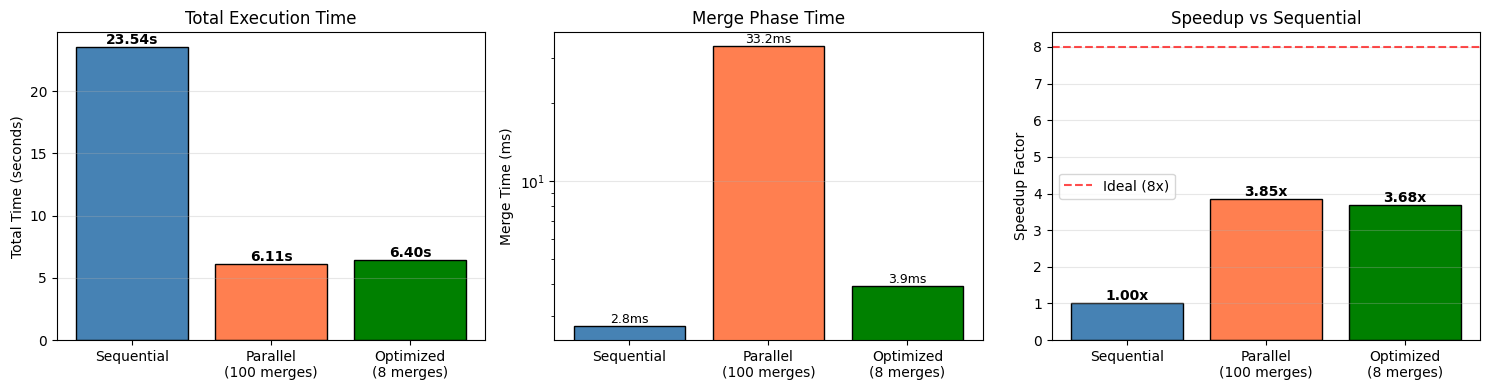

In [16]:
# Visualize three-way comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Total time comparison
ax1 = axes[0]
approaches = ['Sequential', 'Parallel\n(100 merges)', 'Optimized\n(8 merges)']
times = [sequential_time, total_parallel_time, total_optimized_time]
colors = ['steelblue', 'coral', 'green']

bars = ax1.bar(approaches, times, color=colors, edgecolor='black')
ax1.set_ylabel('Total Time (seconds)')
ax1.set_title('Total Execution Time')
ax1.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, times):
    ax1.annotate(f'{t:.2f}s', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Merge time comparison (log scale)
ax2 = axes[1]
merge_times_all = [df['union_ms'].sum(), merge_time*1000, merge_opt_time*1000]

bars = ax2.bar(approaches, merge_times_all, color=colors, edgecolor='black')
ax2.set_ylabel('Merge Time (ms)')
ax2.set_title('Merge Phase Time')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, merge_times_all):
    ax2.annotate(f'{t:.1f}ms', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=9)

# 3. Speedup comparison
ax3 = axes[2]
speedups = [1.0, sequential_time/total_parallel_time, sequential_time/total_optimized_time]

bars = ax3.bar(approaches, speedups, color=colors, edgecolor='black')
ax3.axhline(y=NUM_WORKERS, color='red', linestyle='--', alpha=0.7, label=f'Ideal ({NUM_WORKERS}x)')
ax3.set_ylabel('Speedup Factor')
ax3.set_title('Speedup vs Sequential')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

for bar, s in zip(bars, speedups):
    ax3.annotate(f'{s:.2f}x', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Truly Optimized: Single from_batch() per Worker (No Internal Unions)

In [17]:
def process_worker_single_batch(args):
    """
    Truly optimized: generate ALL tokens, then ONE from_batch() call.
    
    No internal unions at all! Each worker:
    1. Generates all tokens for its assigned workload
    2. Calls from_batch() ONCE with all tokens
    3. Returns serialized HLLSet
    
    Final merge: just 8 unions.
    """
    worker_id, total_tokens_count, seed = args
    
    from core.hllset import HLLSet
    import uuid
    import time
    
    # Generate ALL tokens at once
    gen_start = time.perf_counter()
    tokens = [f"token_{uuid.uuid4().hex}" for _ in range(total_tokens_count)]
    gen_time = time.perf_counter() - gen_start
    
    # ONE from_batch() call - no unions!
    ingest_start = time.perf_counter()
    worker_hll = HLLSet.from_batch(tokens, seed=seed)
    ingest_time = time.perf_counter() - ingest_start
    
    total_time = time.perf_counter() - gen_start
    
    return {
        'worker_id': worker_id,
        'total_tokens': total_tokens_count,
        'gen_time_ms': gen_time * 1000,
        'ingest_time_ms': ingest_time * 1000,
        'total_time_ms': total_time * 1000,
        'throughput': total_tokens_count / ingest_time if ingest_time > 0 else 0,
        'cardinality': worker_hll.cardinality(),
        'roaring': worker_hll.dump_roaring()
    }

In [18]:
# Calculate total tokens per worker (same total as before)
np.random.seed(42)
batch_sizes_v2 = np.random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE + 1, size=NUM_BATCHES)
total_tokens_all = int(batch_sizes_v2.sum())

# Distribute tokens evenly across workers
tokens_per_worker = total_tokens_all // NUM_WORKERS
remainder = total_tokens_all % NUM_WORKERS

worker_token_counts = [tokens_per_worker + (1 if i < remainder else 0) for i in range(NUM_WORKERS)]

print(f"Truly Optimized: {total_tokens_all:,} tokens across {NUM_WORKERS} workers")
print(f"Tokens per worker: ~{tokens_per_worker:,} (balanced)")
print("-" * 60)

Truly Optimized: 5,240,158 tokens across 8 workers
Tokens per worker: ~655,019 (balanced)
------------------------------------------------------------


In [19]:
# Run truly optimized parallel test
work_items_v2 = [(i, worker_token_counts[i], SHARED_SEED) for i in range(NUM_WORKERS)]

print(f"Starting truly optimized ingestion ({NUM_WORKERS} workers, 1 from_batch each)...")
v2_start = time.perf_counter()

with Pool(processes=NUM_WORKERS) as pool:
    v2_results = pool.map(process_worker_single_batch, work_items_v2)

v2_ingest_time = time.perf_counter() - v2_start
print(f"Parallel ingestion complete: {v2_ingest_time:.2f}s")

# Final merge: just 8 unions
print(f"Merging {NUM_WORKERS} worker HLLSets...")
merge_v2_start = time.perf_counter()

final_hll_v2 = HLLSet()
for result in v2_results:
    worker_hll = HLLSet.from_roaring(result['roaring'])
    final_hll_v2 = final_hll_v2.union(worker_hll)

merge_v2_time = time.perf_counter() - merge_v2_start
total_v2_time = time.perf_counter() - v2_start

print(f"Merge complete: {merge_v2_time*1000:.3f}ms")
print("-" * 60)
print(f"Total time: {total_v2_time:.2f}s")
print(f"Final cardinality: {final_hll_v2.cardinality():,.0f}")

Starting truly optimized ingestion (8 workers, 1 from_batch each)...
Parallel ingestion complete: 6.36s
Merging 8 worker HLLSets...
Merge complete: 3.732ms
------------------------------------------------------------
Total time: 6.36s
Final cardinality: 5,453,987


In [20]:
# Four-way comparison
df_v2 = pd.DataFrame(v2_results)

print("\n=== FOUR-WAY COMPARISON ===\n")

print(f"{'Approach':<35} {'Time (s)':>10} {'Speedup':>10} {'Efficiency':>12}")
print("-" * 70)
print(f"{'Sequential (100 batches)':<35} {sequential_time:>10.2f} {'1.00x':>10} {'-':>12}")
print(f"{'Parallel (100 from_batch + 100 union)':<35} {total_parallel_time:>10.2f} {sequential_time/total_parallel_time:>9.2f}x {(sequential_time/total_parallel_time)/NUM_WORKERS*100:>10.1f}%")
print(f"{'Per-worker add() (100 unions total)':<35} {total_optimized_time:>10.2f} {sequential_time/total_optimized_time:>9.2f}x {(sequential_time/total_optimized_time)/NUM_WORKERS*100:>10.1f}%")
print(f"{'Single from_batch (8 unions only)':<35} {total_v2_time:>10.2f} {sequential_time/total_v2_time:>9.2f}x {(sequential_time/total_v2_time)/NUM_WORKERS*100:>10.1f}%")
print()

# Per-worker breakdown
print("Per-Worker Breakdown (Truly Optimized):")
print(f"{'Worker':<8} {'Tokens':>12} {'Gen (ms)':>10} {'Ingest (ms)':>12} {'Throughput':>15}")
print("-" * 60)
for r in v2_results:
    print(f"{r['worker_id']:<8} {r['total_tokens']:>12,} {r['gen_time_ms']:>10.1f} {r['ingest_time_ms']:>12.1f} {r['throughput']/1000:>12.1f}K/s")

print()
print(f"Avg token generation time: {df_v2['gen_time_ms'].mean():.1f}ms")
print(f"Avg ingestion time:        {df_v2['ingest_time_ms'].mean():.1f}ms")
print(f"Avg throughput:            {df_v2['throughput'].mean()/1000:.1f}K tokens/sec")
print()
print(f"Final cardinality: {final_hll_v2.cardinality():,.0f}")


=== FOUR-WAY COMPARISON ===

Approach                              Time (s)    Speedup   Efficiency
----------------------------------------------------------------------
Sequential (100 batches)                 23.54      1.00x            -
Parallel (100 from_batch + 100 union)       6.11      3.85x       48.1%
Per-worker add() (100 unions total)       6.40      3.68x       46.0%
Single from_batch (8 unions only)         6.36      3.70x       46.3%

Per-Worker Breakdown (Truly Optimized):
Worker         Tokens   Gen (ms)  Ingest (ms)      Throughput
------------------------------------------------------------
0             655,020     6028.0        176.7       3706.2K/s
1             655,020     4875.7        342.0       1915.2K/s
2             655,020     5938.7        236.1       2774.5K/s
3             655,020     6020.4        175.9       3723.8K/s
4             655,020     5584.7        305.0       2147.3K/s
5             655,020     5561.8        378.4       1730.8K/s
6        

## 🚀 Optimized: Fast Tokens + NumPy Bulk Union

In [21]:
# Benchmark: Fast Token Generation vs UUID
from core.fast_tokens import numpy_hex_tokens, numpy_int_tokens, range_tokens, worker_tokens
import uuid
import time

N_TOKENS = 100_000

print("Token Generation Benchmark (100K tokens):")
print("-" * 50)

# UUID (baseline - slow)
start = time.perf_counter()
uuid_tokens = [f"token_{uuid.uuid4().hex}" for _ in range(N_TOKENS)]
uuid_time = time.perf_counter() - start
print(f"uuid.uuid4().hex:     {uuid_time*1000:8.1f}ms (baseline)")

# NumPy hex tokens
start = time.perf_counter()
np_hex_tokens = numpy_hex_tokens(N_TOKENS, prefix="token_")
np_hex_time = time.perf_counter() - start
print(f"numpy_hex_tokens:     {np_hex_time*1000:8.1f}ms ({uuid_time/np_hex_time:.1f}x faster)")

# NumPy int tokens
start = time.perf_counter()
np_int_tokens = numpy_int_tokens(N_TOKENS, prefix="token_")
np_int_time = time.perf_counter() - start
print(f"numpy_int_tokens:     {np_int_time*1000:8.1f}ms ({uuid_time/np_int_time:.1f}x faster)")

# Range tokens (fastest)
start = time.perf_counter()
rng_tokens = range_tokens(N_TOKENS, prefix="token_")
rng_time = time.perf_counter() - start
print(f"range_tokens:         {rng_time*1000:8.1f}ms ({uuid_time/rng_time:.1f}x faster)")

# Worker tokens
start = time.perf_counter()
wrk_tokens = worker_tokens(0, N_TOKENS)
wrk_time = time.perf_counter() - start
print(f"worker_tokens:        {wrk_time*1000:8.1f}ms ({uuid_time/wrk_time:.1f}x faster)")

Token Generation Benchmark (100K tokens):
--------------------------------------------------
uuid.uuid4().hex:        500.6ms (baseline)
numpy_hex_tokens:         52.5ms (9.5x faster)
numpy_int_tokens:         36.9ms (13.6x faster)
range_tokens:             18.1ms (27.7x faster)
worker_tokens:            22.8ms (21.9x faster)


In [22]:
# Benchmark: Bulk Union (NumPy) vs Sequential Union
print("\nBulk Union Benchmark:")
print("-" * 50)

# Create 100 HLLSets to merge
test_hlls = []
for i in range(100):
    tokens = numpy_hex_tokens(10_000, prefix=f"batch{i}_", seed=i)
    test_hlls.append(HLLSet.from_batch(tokens))

print(f"Created 100 HLLSets with ~10K tokens each")

# Sequential fold_union (old method)
from core.kernel import Kernel
kernel = Kernel()

start = time.perf_counter()
result_seq = kernel.fold_union(test_hlls)
seq_time = time.perf_counter() - start
print(f"Sequential fold_union:  {seq_time*1000:8.2f}ms")

# NumPy bulk union (new method)
start = time.perf_counter()
result_bulk = HLLSet.bulk_union(test_hlls)
bulk_time = time.perf_counter() - start
print(f"NumPy bulk_union:       {bulk_time*1000:8.2f}ms ({seq_time/bulk_time:.1f}x faster)")

# Verify same result
print(f"\nCardinality (sequential): {result_seq.cardinality():,.0f}")
print(f"Cardinality (bulk):       {result_bulk.cardinality():,.0f}")
print(f"Results match: {abs(result_seq.cardinality() - result_bulk.cardinality()) < 1}")


Bulk Union Benchmark:
--------------------------------------------------
Created 100 HLLSets with ~10K tokens each
Sequential fold_union:      2.42ms
NumPy bulk_union:           0.63ms (3.8x faster)

Cardinality (sequential): 1,092,953
Cardinality (bulk):       1,092,953
Results match: True


In [23]:
def process_worker_optimized(args):
    """
    Fully optimized worker: fast tokens + single from_batch.
    """
    worker_id, total_tokens_count, seed = args
    
    from core.hllset import HLLSet
    from core.fast_tokens import worker_tokens
    import time
    
    # Fast token generation (no uuid!)
    gen_start = time.perf_counter()
    tokens = worker_tokens(worker_id, total_tokens_count)
    gen_time = time.perf_counter() - gen_start
    
    # Single from_batch call
    ingest_start = time.perf_counter()
    worker_hll = HLLSet.from_batch(tokens, seed=seed)
    ingest_time = time.perf_counter() - ingest_start
    
    total_time = time.perf_counter() - gen_start
    
    return {
        'worker_id': worker_id,
        'total_tokens': total_tokens_count,
        'gen_time_ms': gen_time * 1000,
        'ingest_time_ms': ingest_time * 1000,
        'total_time_ms': total_time * 1000,
        'throughput': total_tokens_count / ingest_time if ingest_time > 0 else 0,
        'cardinality': worker_hll.cardinality(),
        'roaring': worker_hll.dump_roaring()
    }

In [24]:
# Run fully optimized parallel test
from multiprocessing import Pool
from core.hllset import HLLSet
from core.constants import SHARED_SEED
import time
import numpy as np

# Configuration (self-contained)
NUM_WORKERS = 8
NUM_BATCHES = 100
MIN_BATCH_SIZE = 1_000
MAX_BATCH_SIZE = 100_000

# Calculate total tokens per worker
np.random.seed(42)
batch_sizes_opt = np.random.randint(MIN_BATCH_SIZE, MAX_BATCH_SIZE + 1, size=NUM_BATCHES)
total_tokens_all = int(batch_sizes_opt.sum())

tokens_per_worker = total_tokens_all // NUM_WORKERS
remainder = total_tokens_all % NUM_WORKERS
worker_token_counts = [tokens_per_worker + (1 if i < remainder else 0) for i in range(NUM_WORKERS)]

print(f"\n🚀 FULLY OPTIMIZED: Fast tokens + NumPy bulk union")
print(f"Total tokens: {total_tokens_all:,} across {NUM_WORKERS} workers")
print("-" * 60)

work_items_opt = [(i, worker_token_counts[i], SHARED_SEED) for i in range(NUM_WORKERS)]

opt_start = time.perf_counter()

with Pool(processes=NUM_WORKERS) as pool:
    opt_results = pool.map(process_worker_optimized, work_items_opt)

opt_ingest_time = time.perf_counter() - opt_start
print(f"Parallel ingestion complete: {opt_ingest_time:.2f}s")

# NumPy bulk union (instead of sequential)
print(f"Merging {NUM_WORKERS} worker HLLSets with bulk_union...")
merge_opt2_start = time.perf_counter()

worker_hlls = [HLLSet.from_roaring(r['roaring']) for r in opt_results]
final_hll_opt = HLLSet.bulk_union(worker_hlls)

merge_opt2_time = time.perf_counter() - merge_opt2_start
total_opt_time = time.perf_counter() - opt_start

print(f"Bulk union complete: {merge_opt2_time*1000:.3f}ms")
print("-" * 60)
print(f"Total time: {total_opt_time:.2f}s")
print(f"Final cardinality: {final_hll_opt.cardinality():,.0f}")


🚀 FULLY OPTIMIZED: Fast tokens + NumPy bulk union
Total tokens: 5,240,158 across 8 workers
------------------------------------------------------------
Parallel ingestion complete: 0.91s
Merging 8 worker HLLSets with bulk_union...
Bulk union complete: 4.675ms
------------------------------------------------------------
Total time: 0.91s
Final cardinality: 5,247,444


In [25]:
import pandas as pd
# Final comparison: All approaches
df_opt = pd.DataFrame(opt_results)

print("\n" + "=" * 80)
print("                    FINAL PERFORMANCE COMPARISON")
print("=" * 80)

print(f"\n{'Approach':<45} {'Time (s)':>10} {'Speedup':>10} {'Efficiency':>12}")
print("-" * 80)
print(f"{'Sequential (uuid + 100 unions)':<45} {sequential_time:>10.2f} {'1.00x':>10} {'-':>12}")
print(f"{'Parallel uuid (100 from_batch + 100 union)':<45} {total_parallel_time:>10.2f} {sequential_time/total_parallel_time:>9.2f}x {(sequential_time/total_parallel_time)/NUM_WORKERS*100:>10.1f}%")
print(f"{'Single from_batch + uuid (8 unions)':<45} {total_v2_time:>10.2f} {sequential_time/total_v2_time:>9.2f}x {(sequential_time/total_v2_time)/NUM_WORKERS*100:>10.1f}%")
print(f"{'🚀 OPTIMIZED: fast_tokens + bulk_union':<45} {total_opt_time:>10.2f} {sequential_time/total_opt_time:>9.2f}x {(sequential_time/total_opt_time)/NUM_WORKERS*100:>10.1f}%")
print()

# Breakdown
print("Per-Worker Breakdown (Fully Optimized):")
print(f"{'Worker':<8} {'Tokens':>12} {'Gen (ms)':>10} {'Ingest (ms)':>12} {'Throughput':>15}")
print("-" * 60)
for r in opt_results:
    print(f"{r['worker_id']:<8} {r['total_tokens']:>12,} {r['gen_time_ms']:>10.1f} {r['ingest_time_ms']:>12.1f} {r['throughput']/1000:>12.1f}K/s")

print()
print(f"Avg token generation: {df_opt['gen_time_ms'].mean():.1f}ms (was {df_v2['gen_time_ms'].mean():.1f}ms with uuid)")
print(f"Avg ingestion time:   {df_opt['ingest_time_ms'].mean():.1f}ms")
print(f"Avg throughput:       {df_opt['throughput'].mean()/1000:.1f}K tokens/sec")
print()

# Improvement summary
print("=" * 80)
print("IMPROVEMENT SUMMARY")
print("=" * 80)
token_gen_speedup = df_v2['gen_time_ms'].mean() / df_opt['gen_time_ms'].mean()
overall_speedup = sequential_time / total_opt_time
efficiency = overall_speedup / NUM_WORKERS * 100

print(f"Token generation speedup: {token_gen_speedup:.1f}x (fast_tokens vs uuid)")
print(f"Overall speedup:          {overall_speedup:.2f}x (vs sequential)")
print(f"Parallel efficiency:      {efficiency:.1f}% (ideal = 100%)")
print(f"Time saved:               {sequential_time - total_opt_time:.2f}s ({(1 - total_opt_time/sequential_time)*100:.1f}%)")


                    FINAL PERFORMANCE COMPARISON

Approach                                        Time (s)    Speedup   Efficiency
--------------------------------------------------------------------------------
Sequential (uuid + 100 unions)                     23.54      1.00x            -
Parallel uuid (100 from_batch + 100 union)          6.11      3.85x       48.1%
Single from_batch + uuid (8 unions)                 6.36      3.70x       46.3%
🚀 OPTIMIZED: fast_tokens + bulk_union               0.91     25.85x      323.1%

Per-Worker Breakdown (Fully Optimized):
Worker         Tokens   Gen (ms)  Ingest (ms)      Throughput
------------------------------------------------------------
0             655,020      325.5        320.3       2044.8K/s
1             655,020      320.0        314.0       2085.7K/s
2             655,020      350.6        333.3       1965.5K/s
3             655,020      461.0        303.1       2161.0K/s
4             655,020      352.8        319.4       20

/tmp/ipykernel_128873/2768318450.py:49: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/alexmy/SGS/SGS_lib/fractal_manifold/fractal_manifold/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


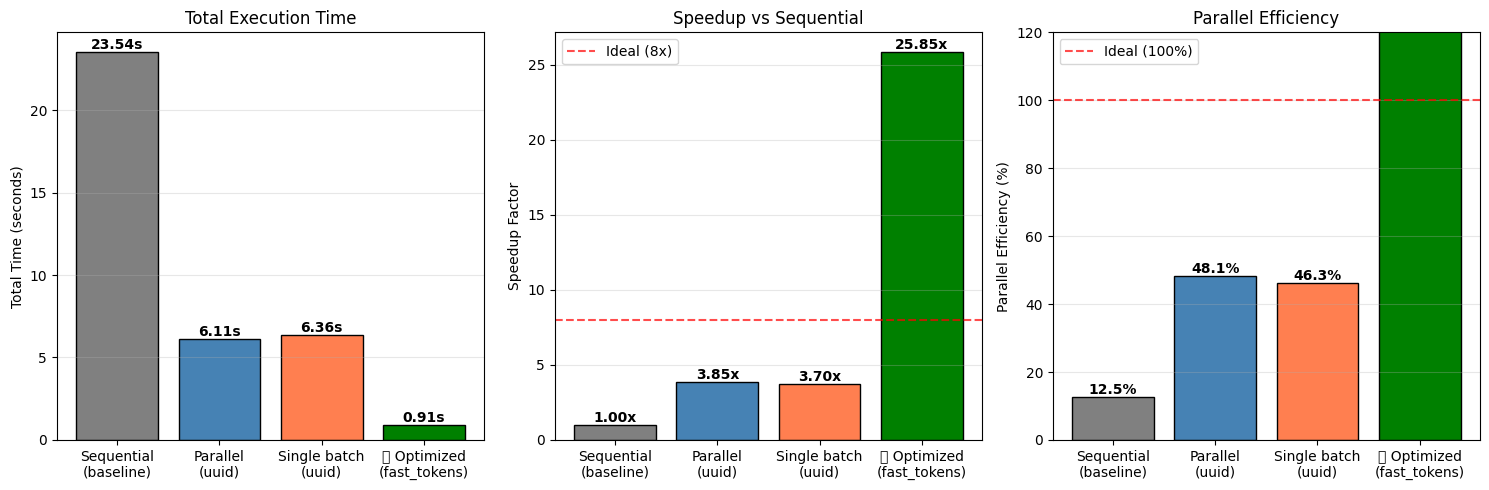

In [26]:
# Visualization: Final comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

approaches = ['Sequential\n(baseline)', 'Parallel\n(uuid)', 'Single batch\n(uuid)', '🚀 Optimized\n(fast_tokens)']
times = [sequential_time, total_parallel_time, total_v2_time, total_opt_time]
colors = ['gray', 'steelblue', 'coral', 'green']

# 1. Total time comparison
ax1 = axes[0]
bars = ax1.bar(approaches, times, color=colors, edgecolor='black')
ax1.set_ylabel('Total Time (seconds)')
ax1.set_title('Total Execution Time')
ax1.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, times):
    ax1.annotate(f'{t:.2f}s', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Speedup comparison  
ax2 = axes[1]
speedups = [1.0, sequential_time/total_parallel_time, sequential_time/total_v2_time, sequential_time/total_opt_time]
bars = ax2.bar(approaches, speedups, color=colors, edgecolor='black')
ax2.axhline(y=NUM_WORKERS, color='red', linestyle='--', alpha=0.7, label=f'Ideal ({NUM_WORKERS}x)')
ax2.set_ylabel('Speedup Factor')
ax2.set_title('Speedup vs Sequential')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar, s in zip(bars, speedups):
    ax2.annotate(f'{s:.2f}x', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Efficiency comparison
ax3 = axes[2]
efficiencies = [100/NUM_WORKERS, (sequential_time/total_parallel_time)/NUM_WORKERS*100, 
                (sequential_time/total_v2_time)/NUM_WORKERS*100, (sequential_time/total_opt_time)/NUM_WORKERS*100]
bars = ax3.bar(approaches, efficiencies, color=colors, edgecolor='black')
ax3.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='Ideal (100%)')
ax3.set_ylabel('Parallel Efficiency (%)')
ax3.set_title('Parallel Efficiency')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')
ax3.set_ylim(0, 120)

for bar, e in zip(bars, efficiencies):
    ax3.annotate(f'{e:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()